#  Исследование технологического процесса очистки золота

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, используя данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

***Описание данных***

*Технологический процесс:*

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Параметры этапов:*

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

*Возможные значения для блока `[этап]`:*

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

*Возможные значения для блока `[тип_параметра]`:*

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

**Эффективность обогащения рассчитывается по формуле:**

**Recovery = ((C * (F-T)) / (F * (C-T))) * 100%**

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

*Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

Для решения задачи необходимо использовать метрику качества **sMAPE**.

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата `rougher.output.recovery`;
* эффективность обогащения финального концентрата `final.output.recovery`.

<u>Итоговая метрика складывается из двух величин:</u>

**Итоговое sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)**

## Подготовка данных

In [ ]:
# загружаем необходимые библиотеки и модули

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

warnings.filterwarnings("ignore")

In [ ]:
# загружаем данные
data_train = pd.read_csv('/datasets/gold_industry_train.csv')
data_test = pd.read_csv('/datasets/gold_industry_test.csv')
data_full = pd.read_csv('/datasets/gold_industry_full.csv')

In [ ]:
# выведем общую информацию
data_full.info()
data_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


Всего в датасете 87 столбцов и 19439 строк, есть пропущенные значения.

### Проверим, что эффективность обогащения рассчитана правильно

Вычислим её на обучающей выборке для признака `rougher.output.recovery` по формуле:

**Recovery = ((C * (F-T)) / (F * (C-T))) * 100%**

In [ ]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

# посчитаем эффективность обогащения чернового концентрата
rougher_output_recovery_calc = ((C * (F-T)) / (F * (C-T))) * 100

Вычислим среднюю абсолютную ошибку между посчитанными данными и предоставленными и построим графики сравниваемых распределений:

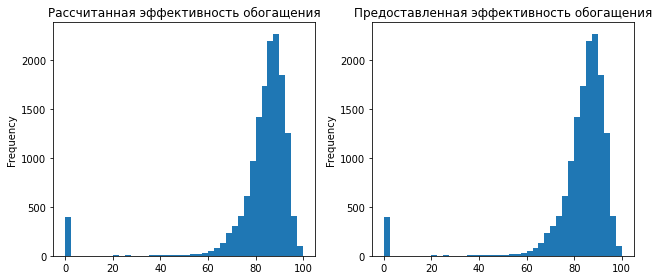

MAE = 9.83758577644259e-15


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

rougher_output_recovery_calc.plot(kind='hist',bins=40, ax = ax1)
ax1.set_title('Рассчитанная эффективность обогащения')


data_train ["rougher.output.recovery"].plot(kind='hist',bins = 40, ax = ax2)
ax2.set_title('Предоставленная эффективность обогащения')

plt.tight_layout()
plt.show()

print('MAE =', mean_absolute_error(rougher_output_recovery_calc,data_train ["rougher.output.recovery"]))

Значение MAE небольшое, а распределения, как видно на гистограммах, одинаковые. Значит, эффективность обогащения рассчитана правильно.

### Сравним обучающую и тестовую выборку

В задании сказано, что некоторые параметры в тестовой выборке (в отличие от обучающей) отсутствуют, так как замеряются и/или рассчитываются значительно позже. Сравним обучающую  и тестовую выборки:

In [ ]:
size_train = len(data_train)/len(data_full)*100
size_test = len(data_test)/len(data_full)*100
print(f'Размер обучающей выборки: {round(size_train,2)}%')
print(f'Размер тестовой выборки: {round(size_test,2)}%')

Размер обучающей выборки: 75.0%
Размер тестовой выборки: 25.0%


In [ ]:
print('Количество столбцов в обучающей выборке:', data_train.shape[1])
print('Количество столбцов в тестовой выборке:', data_test.shape[1])

Количество столбцов в обучающей выборке: 87
Количество столбцов в тестовой выборке: 53


In [ ]:
# выведем на экран столбцы обучающей выборки, которых нет в тестовых данных,
# исключение -  'rougher.output.recovery' и 'final.output.recovery' - это целевые признаки, которые есть в обучающей выборке,
# а для тестовых данных их можно востановить из data_full

missing_columns = list(set(data_train) ^ set(data_test))
missing_columns = [col for col in missing_columns if col not in ('rougher.output.recovery', 'final.output.recovery')]
display(missing_columns)

['primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_sol',
 'secondary_cleaner.output.tail_ag',
 'final.output.tail_sol',
 'secondary_cleaner.output.tail_pb',
 'final.output.concentrate_au',
 'rougher.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_au',
 'final.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.calculation.au_pb_ratio',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.tail_sol',
 'final.output.concentrate_sol',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.sulfate_to_au_concentrate',
 'secondary_cleaner.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'secondary_cleaner.output.tail_au',
 'final.output.concentrate_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.concentrate_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.tail_pb',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_ag',
 'final.output.tail_ag',
 'primary_cleaner.out

Отсутствующие столбцы в тестовой выборке - это данные о концентрации веществ после различных этапов обработки золотоносной руды. Следовательно, необходимо исходить из того факта, что тестовые данные - это то, что будет доступно на этапе применения модели. В таком случае выровняем обучающую и тестовую выборки:

In [ ]:
data_train = data_train[data_train.columns.drop(missing_columns)]
data_train.shape

(14579, 55)

Следующим шагом добавим к тестовым данным целевые признаки. В качестве индексов будем использовать столбец date, который содержит уникальные значения:

In [ ]:
# сделаем дату индексом
data_full = data_full.set_index('date')
data_test = data_test.set_index('date')
data_train = data_train.set_index('date')

# добавим в тестовую выборку целевые признаки
columns_to_copy = ['rougher.output.recovery', 'final.output.recovery']
data_test[columns_to_copy] = data_full.loc[data_test.index, columns_to_copy]

data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 non-null

Проверим наличие пропусков в целевых признаках в обучающей и тестовой выборках:

In [ ]:
print(data_train[['rougher.output.recovery', 'final.output.recovery']].isnull().sum())
print(data_test[['rougher.output.recovery', 'final.output.recovery']].isnull().sum())

rougher.output.recovery    0
final.output.recovery      0
dtype: int64
rougher.output.recovery    0
final.output.recovery      0
dtype: int64


### Предобработка данных

Проверим данные на явные дубликаты:

In [ ]:
print('Количество явных дубликатов в обучающей выборке:',data_train.duplicated().sum())
print('Количество явных дубликатов в тестовой выборке:',data_test.duplicated().sum())

Количество явных дубликатов в обучающей выборке: 0
Количество явных дубликатов в тестовой выборке: 0


Проверим наличие аномалий и вбросов в обучающей выборке:

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,14579.000000,14579.000000,14579.000000,14579.000000,14579.000000,14579.000000,14579.000000,14578.000000,14579.000000,14579.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,-484.971102,14.823764,-460.046154,15.394610,-487.973768,11.949009,-486.338692,18.927405,-505.688730,66.759066
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,48.795359,4.863659,67.933026,5.405045,35.231439,5.241169,38.726292,5.550829,37.347370,10.619709
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,-500.704937,11.889685,-500.184081,10.977413,-500.451167,8.947381,-500.129137,14.985721,-500.755346,63.114596
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,-499.820809,14.957945,-499.424528,14.963654,-499.772653,11.000057,-499.926255,19.960798,-500.054273,67.962788
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,-498.048862,17.125406,-400.083087,18.012762,-498.182011,14.002573,-499.285414,23.038231,-499.506135,72.598187
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-123.307487,100.000000


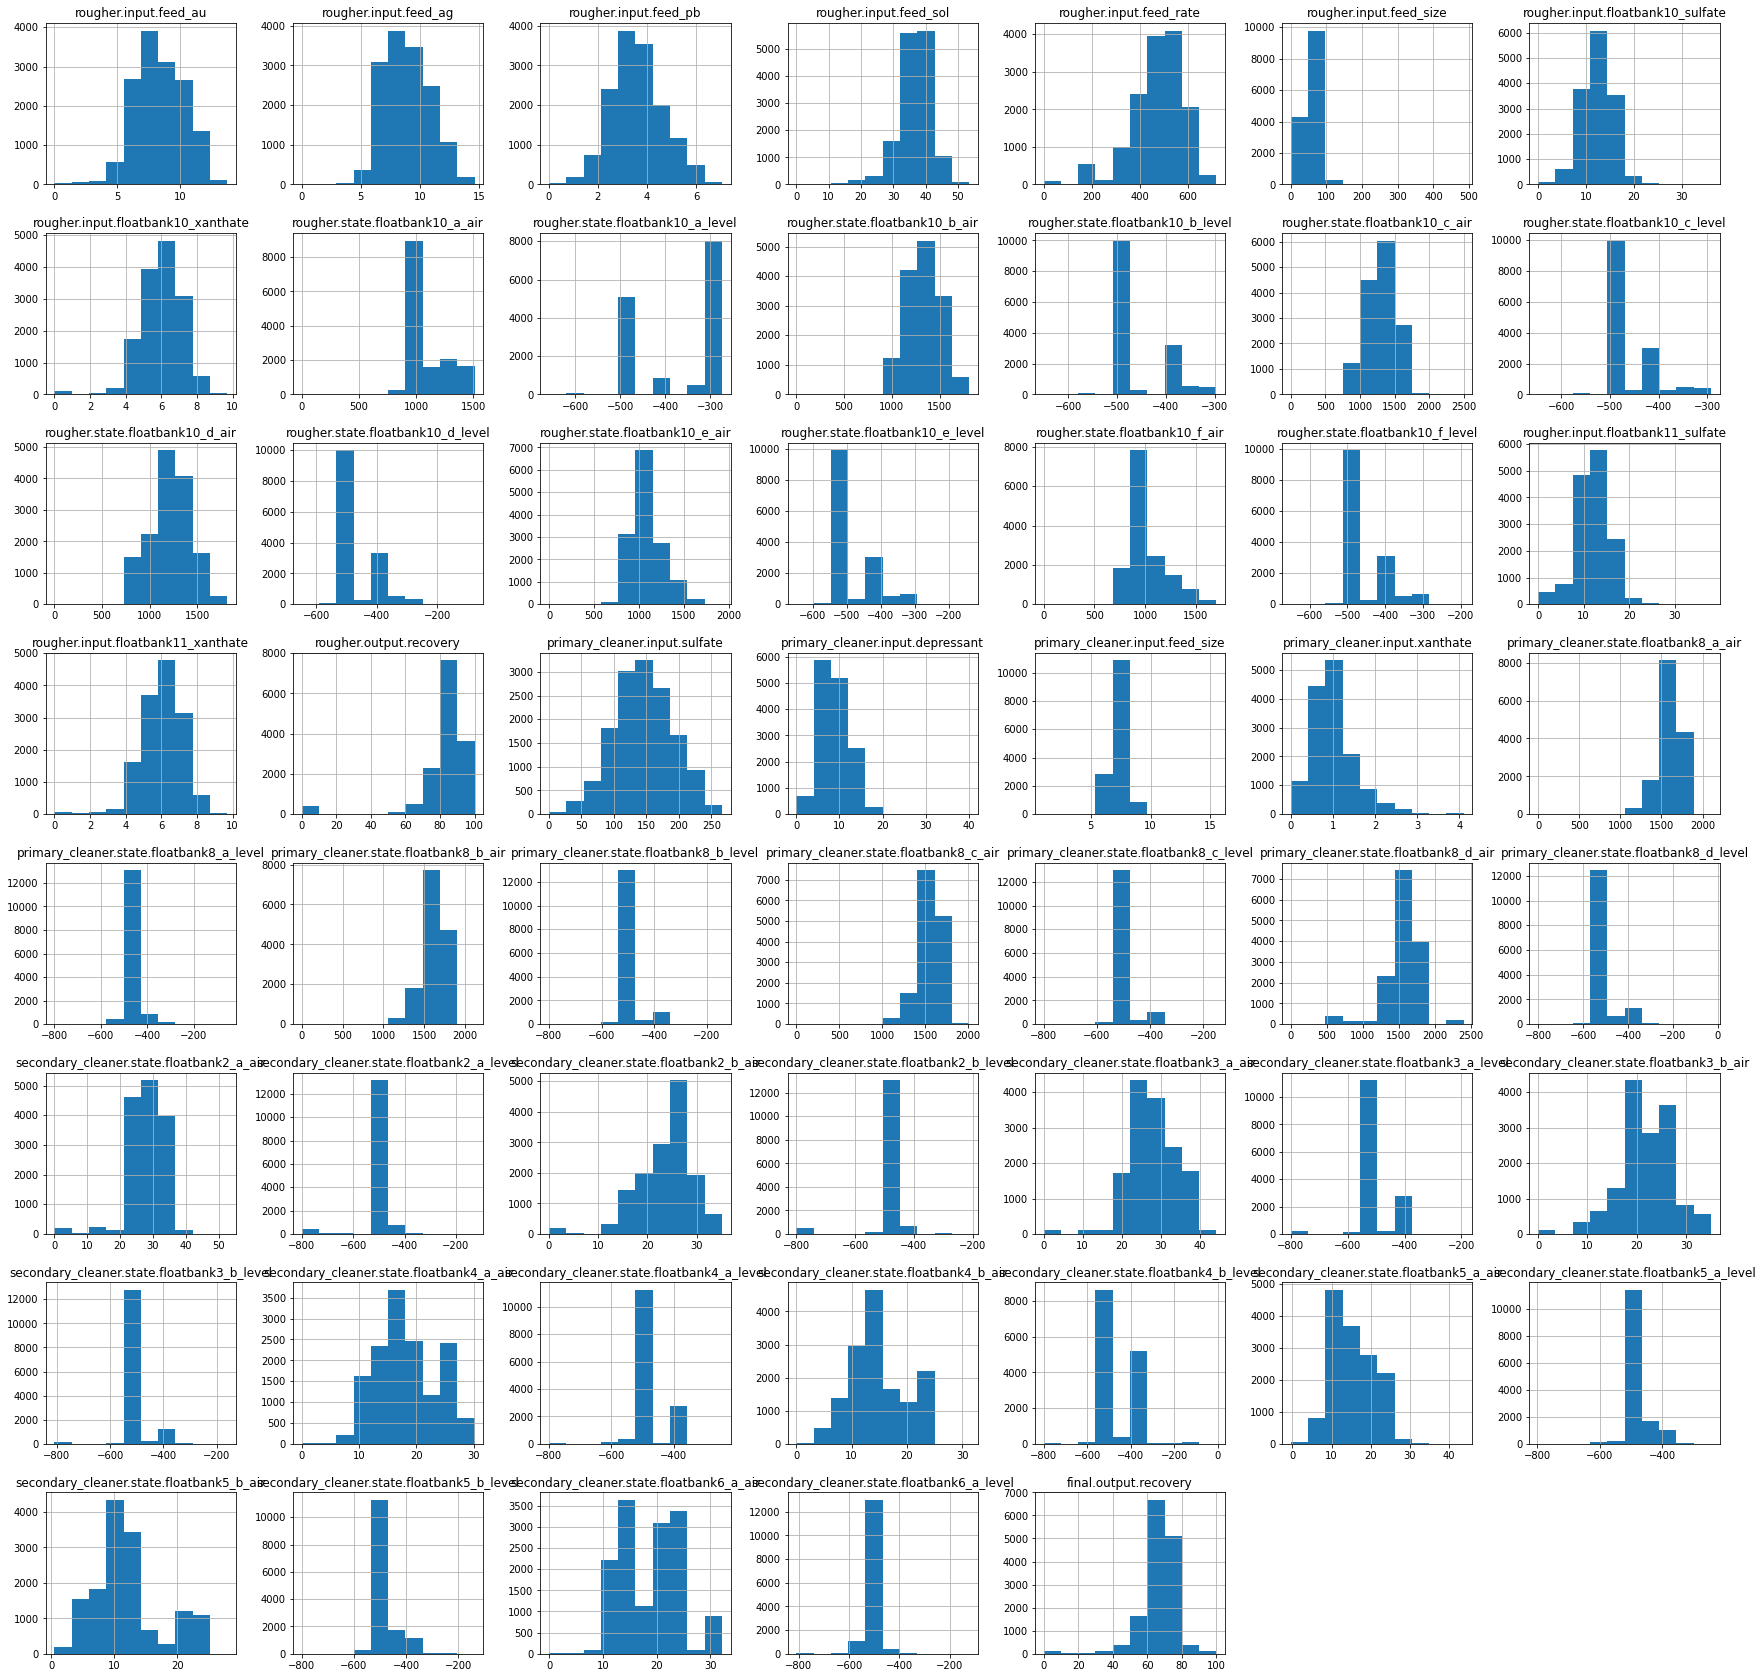

In [ ]:
display(data_train.describe())
data_train.hist(figsize=(30,30));

В data_train есть аномалии, но так как данных не очень много, очистим только те столбцы, где есть явные ошибки в расчетах. Если сравнить минимальные значения столбцов, то можно заметить, что есть параметры, где отрицательные значения являются редкими:

In [ ]:
(data_train[['rougher.state.floatbank10_a_air',
             'secondary_cleaner.state.floatbank5_a_air',
             'secondary_cleaner.state.floatbank6_a_air']] < 0).sum()

rougher.state.floatbank10_a_air              4
secondary_cleaner.state.floatbank5_a_air    24
secondary_cleaner.state.floatbank6_a_air     1
dtype: int64

Удалим их:

In [ ]:
data_train = data_train[(data_train[['rougher.state.floatbank10_a_air',
                                    'secondary_cleaner.state.floatbank5_a_air',
                                    'secondary_cleaner.state.floatbank6_a_air']] >= 0).all(axis=1)]

Аналогичные значения удалим и в тестовой выборке:

In [ ]:
data_test.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4860.000000,4860.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924,85.750584,67.923574
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186,6.648023,8.414134
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800,18.491446,5.586496
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501,82.354512,63.939233
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769,86.839027,68.744713
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134,90.145117,73.037434
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459,100.000000,100.000000


In [ ]:
(data_test['secondary_cleaner.state.floatbank5_a_air'] < 0).sum()

4

In [ ]:
data_test = data_test[data_test['secondary_cleaner.state.floatbank5_a_air'] >= 0]

С пропусками в обучающей и тестовой выборках поступим следующим образом: для восстановления даных будем использовать метод **ffill**, так как в описании проекта сказано, что соседние по времени параметры часто похожи.

In [ ]:
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

In [ ]:
print('Количество пропусков в data_train:',data_train.isnull().sum().sum())
print('Количество пропусков в data_test:',data_test.isnull().sum().sum())

Количество пропусков в data_train: 0
Количество пропусков в data_test: 0


## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Соберем необходимые данные для металлов в 3 датафрейма:

In [ ]:
au = data_full[['rougher.input.feed_au',
                'rougher.output.concentrate_au',
                'primary_cleaner.output.concentrate_au',
                'final.output.concentrate_au']]

ag = data_full[['rougher.input.feed_ag',
                'rougher.output.concentrate_ag',
                'primary_cleaner.output.concentrate_ag',
                'final.output.concentrate_ag']]

pb = data_full[['rougher.input.feed_pb',
                'rougher.output.concentrate_pb',
                'primary_cleaner.output.concentrate_pb',
                'final.output.concentrate_pb']]

Напишем функцию для построения графиков изменения концентрации металлов на различных этапах очистки руды:

In [ ]:
def concentrate (df,substance):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.set(style="darkgrid")

    for column in df.columns:
        sns.kdeplot(df[column], shade=True, ax=ax, label=column)

    ax.legend()
    ax.set_title(f'Изменение концентрации {substance}')
    ax.set_xlabel('Концентрация')
    ax.set_ylabel('Частота')

    plt.show()

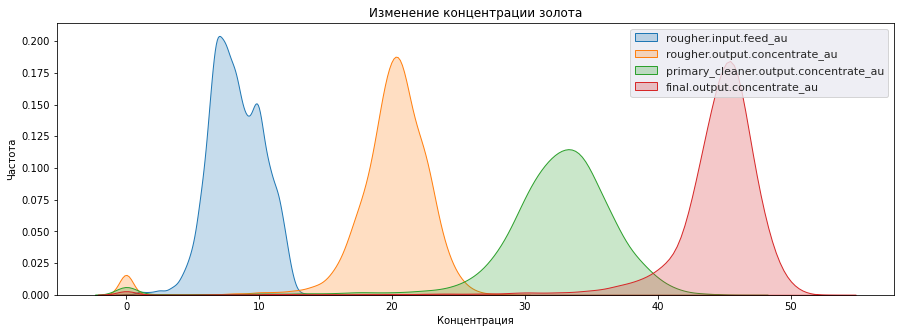

In [ ]:
# график для золота
concentrate (au,'золота')

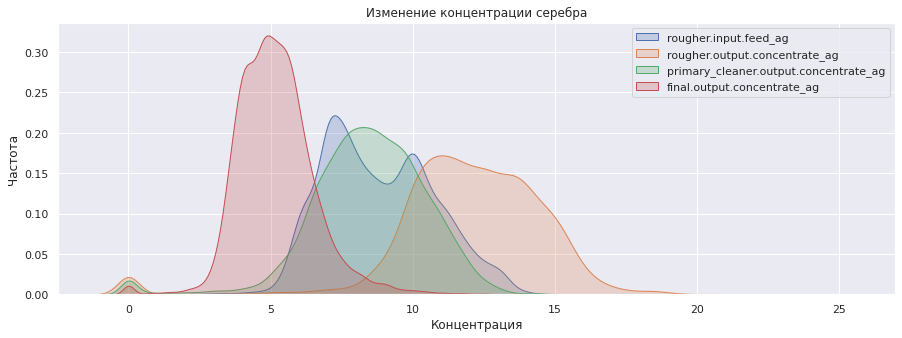

In [ ]:
# график для серебра
concentrate (ag,'серебра')

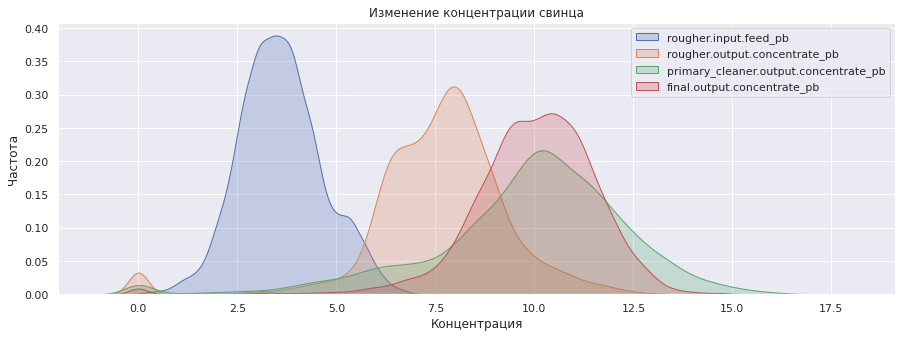

In [ ]:
# график для свинца
concentrate (pb,'свинца')

**По графикам можно сделать следующие выводы:**

- концентрация золота в сырье на каждом этапе очистки растет;
- концентрация серебра после флотации увеличивается, после первичной очистки уменьшается до изначальных значений, а после вторичной очистки достигает своего минимума;
- концентрация свинца с каждым этап увеличивается, за исключением первичной и вторичной очистки, когда содержание свинца остается примерно на одном уровне. Возможно, стоит пересмотреть технологию очистки или использовать другие реагенты;
- в данных есть вбросы - значения около нуля, которые необходимо будет удалить в тестовой и обучающей выборках.

### Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках.

Построим график для сравнения двух выборок:

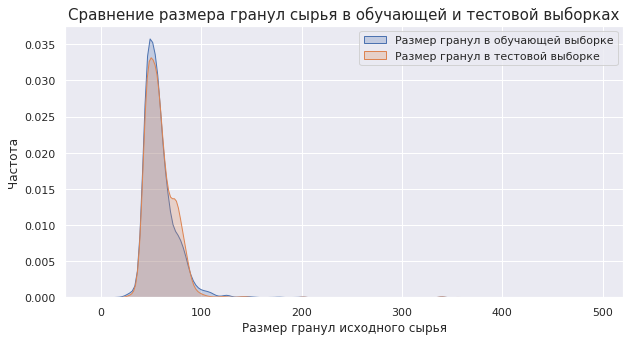

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set(style="darkgrid")

sns.kdeplot(data_train['rougher.input.feed_size'], shade=True, ax=ax, label = "Размер гранул в обучающей выборке")
sns.kdeplot(data_test['rougher.input.feed_size'], shade=True, ax=ax, label = "Размер гранул в тестовой выборке")
ax.legend()
ax.set_title(f'Сравнение размера гранул сырья в обучающей и тестовой выборках', size=15)
ax.set_xlabel('Размер гранул исходного сырья')
ax.set_ylabel('Частота')

plt.show()

Выведем значения описательной статистики:

In [ ]:
print('Обучающая выборка:')
print(data_train['rougher.input.feed_size'].describe())
print('')
print('Тестовая выборка:')
print(data_test['rougher.input.feed_size'].describe())

Обучающая выборка:
count    14551.000000
mean        59.092864
std         22.918818
min          0.049194
25%         47.333133
50%         54.473272
75%         64.499062
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Тестовая выборка:
count    4855.000000
mean       59.145874
std        19.518715
min         0.046369
25%        47.615219
50%        55.461058
75%        66.542698
max       363.989699
Name: rougher.input.feed_size, dtype: float64


Если смотреть на график, то различия в размерах гранул обучающей и тестовой выборок небольшие, распределения похожи. Описательная статистика также в пользу схожести распределений.

### Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Создадим датасет с концентрациями металлов на различных этапах очистки руды:

In [ ]:
total_concentration = pd.DataFrame()

total_concentration['rougher_input'] = (data_full['rougher.input.feed_au'] +
                                        data_full['rougher.input.feed_ag'] +
                                        data_full['rougher.input.feed_pb'])

total_concentration['rougher_output'] = (data_full['rougher.output.concentrate_au'] +
                                         data_full['rougher.output.concentrate_ag'] +
                                         data_full['rougher.output.concentrate_pb'])

total_concentration['primary_output']  = (data_full['primary_cleaner.output.concentrate_au'] +
                                          data_full['primary_cleaner.output.concentrate_ag'] +
                                          data_full['primary_cleaner.output.concentrate_pb'])

total_concentration['final_output'] = (data_full['final.output.concentrate_au'] +
                                       data_full['final.output.concentrate_ag'] +
                                       data_full['final.output.concentrate_pb'])

In [ ]:
total_concentration.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rougher_input   19339 non-null  float64
 1   rougher_output  19439 non-null  float64
 2   primary_output  19323 non-null  float64
 3   final_output    19438 non-null  float64
dtypes: float64(4)
memory usage: 1.2+ MB


Построим график изменения концентрации металлов:

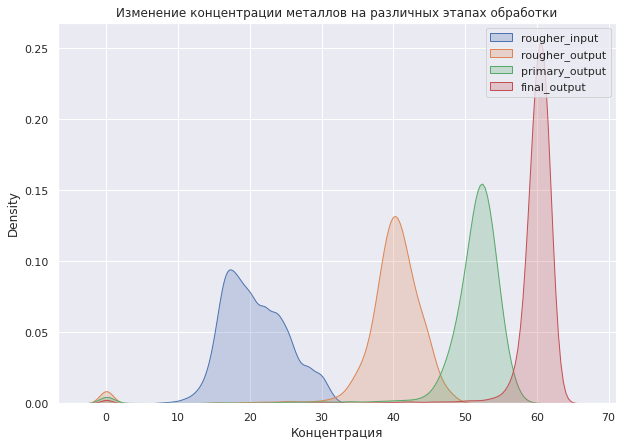

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(style="darkgrid")

for column in total_concentration.columns:
    sns.kdeplot(total_concentration[column], shade=True, ax=ax, label=column)

ax.legend()
ax.set_title(f'Изменение концентрации металлов на различных этапах обработки')
ax.set_xlabel('Концентрация')

plt.show()

Как видно на графике, наибольший разброс значений концентрации в исходном сырье, по мере прохождения этапов обработки концентрация металлов увеличивается (больше металлов детектируется), а разброс значений уменьшается. Также видны аномальные значения в районе 0.

В дальнейшем нас будет интересовать концентрация металлов только в исходном сырье (`rougher.input.feed`), так как только она используется при построении модели (остальные столбцы не вошли в тестовые и соответсвенно в обучающие данные). Построим боксплот для `rougher.input.feed`:

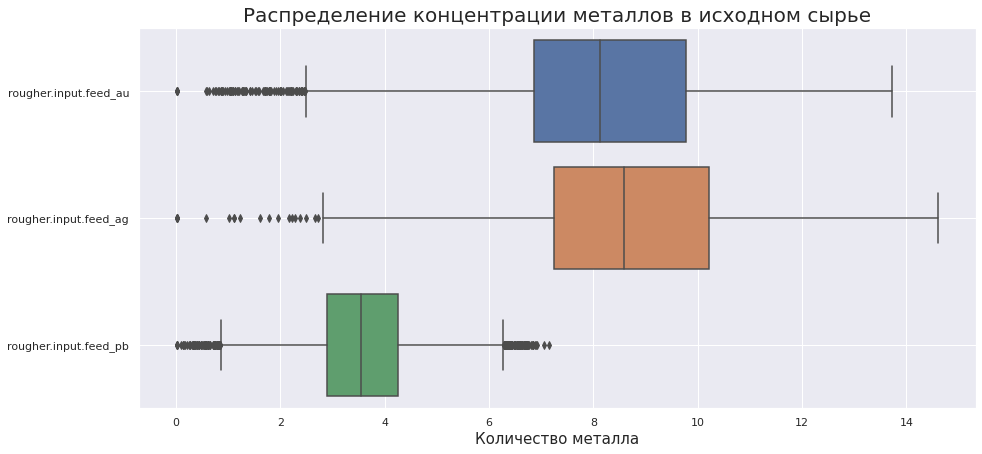

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Распределение концентрации металлов в исходном сырье', fontsize=20)
sns.boxplot(data=data_full[['rougher.input.feed_au',
                            'rougher.input.feed_ag',
                            'rougher.input.feed_pb']], orient='h')

plt.xlabel('Количество металла', fontsize=15)
plt.grid(True)

plt.show()


Аномалии находятся в основном около 0. Чтобы избавиться от части вбросов, удалим значения, которые меньше 1-го перцентиля:

In [ ]:
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data_full = data_full.reset_index(drop=True)

In [ ]:
# напишем функцию для удаления данных
def remove_percentile_rows(data_train, data_test, data_full, columns):
    for col in columns:
        # вычисляем 1-й перцентиль для столбца в data_full
        percentile_1 = data_full[col].quantile(0.01)

        # фильтруем строки в data_full, где значение в столбце меньше 1-го перцентиля
        outlier_rows = data_full[data_full[col] < percentile_1]

        # удаляем найденные строки из data_train и data_test
        data_train = data_train[~data_train.index.isin(outlier_rows.index)]
        data_test = data_test[~data_test.index.isin(outlier_rows.index)]

        # выводим количество удаленных строк для текущего столбца
        print(f"Удалено {len(outlier_rows)} строк в столбце '{col}' со значениями меньше 1-го перцентиля.")

    return data_train, data_test

# список столбцов для обработки
columns_to_process = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']

# вызываем функцию и сохраняем обновленные выборки
data_train, data_test = remove_percentile_rows(data_train, data_test, data_full, columns_to_process)

Удалено 195 строк в столбце 'rougher.input.feed_au' со значениями меньше 1-го перцентиля.
Удалено 195 строк в столбце 'rougher.input.feed_ag' со значениями меньше 1-го перцентиля.
Удалено 194 строк в столбце 'rougher.input.feed_pb' со значениями меньше 1-го перцентиля.


### Проверка на мультиколлинеарность признаков

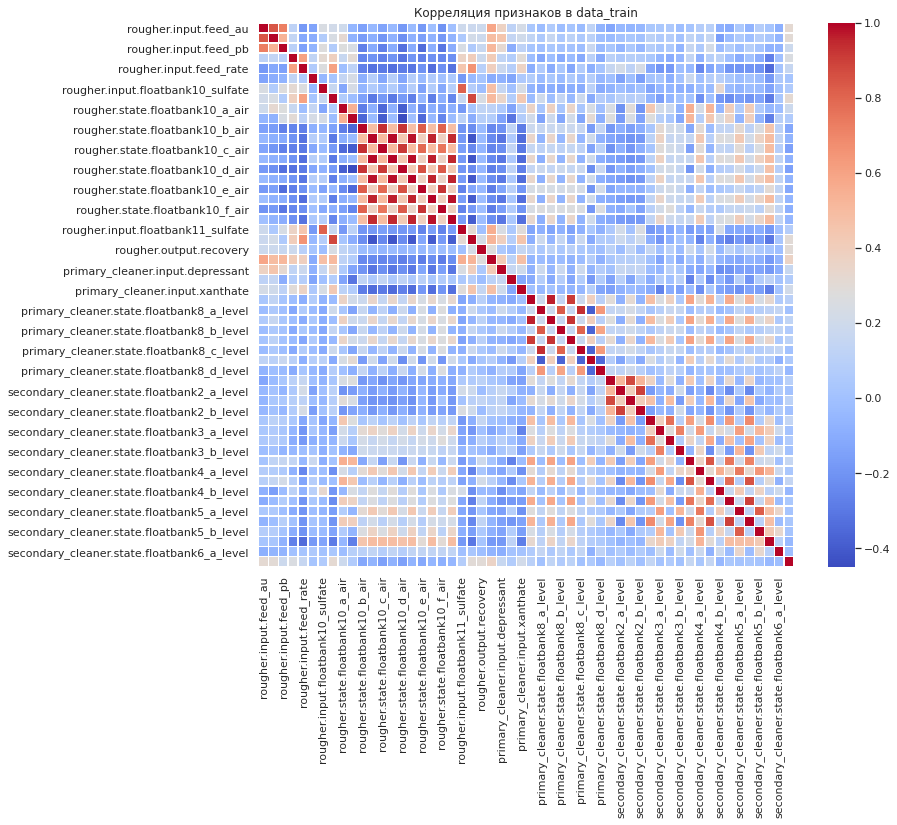

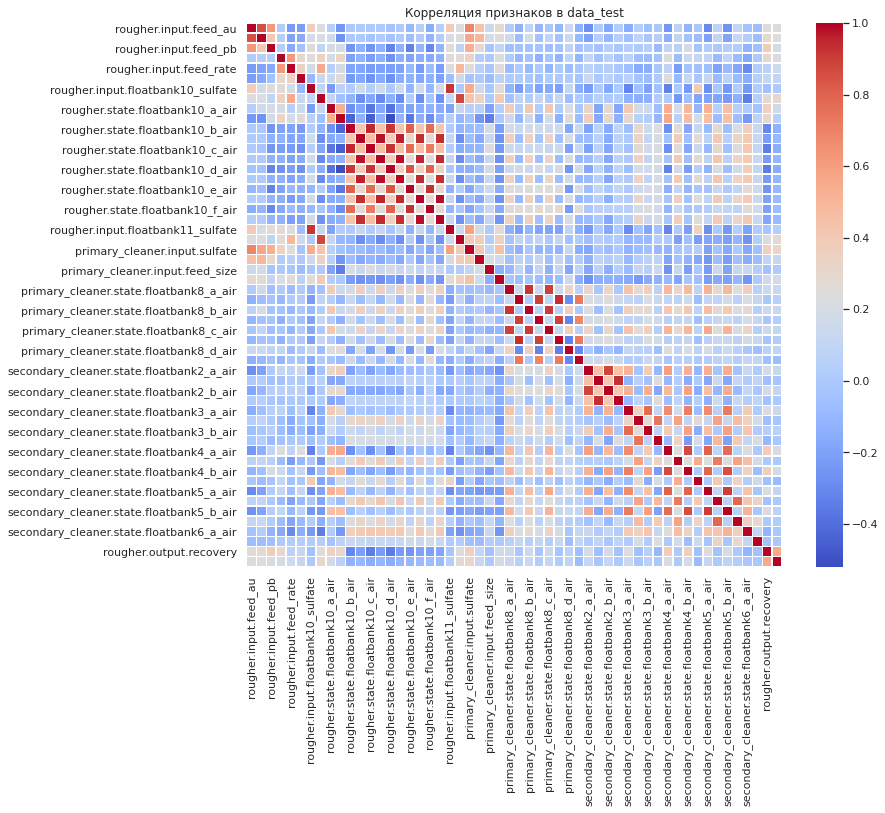

In [ ]:
# вычисляем корреляцию признаков в data_train
corr_matrix_train = data_train.corr()

# вычисляем корреляцию признаков в data_test
corr_matrix_test = data_test.corr()

plt.figure(figsize=(12, 10))

# хитмэп для data_train
sns.heatmap(corr_matrix_train, cmap='coolwarm', linewidths=0.5, ax=plt.gca())
plt.title('Корреляция признаков в data_train')
plt.show()


plt.figure(figsize=(12, 10))

# хитмэп для data_test
sns.heatmap(corr_matrix_test, cmap='coolwarm', linewidths=0.5, ax=plt.gca())
plt.title('Корреляция признаков в data_test')
plt.show()

В данных есть мультиколлинеарные признаки, попробуем решить проблему с помощью регуляризации.

## Модель

### Напишем функцию для вычисления итоговой sMAPE.

In [ ]:
# функция для вычисления smape
def calculate_smape(target, predictions):

    smape = 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

    return smape

In [ ]:
# функция для вычисления итоговой smape
def calculate_total_smape(smape_rougher, smape_final):

    total_smape = 0.25 * smape_rougher + 0.75 * smape_final

    return total_smape

### Подготовим выборки

Выделим из выборок целевые признаки:

In [ ]:
# подготовка обучающей выборки
train_features = data_train.drop(['final.output.recovery', 'rougher.output.recovery'], axis='columns')
train_rougher_target = data_train['rougher.output.recovery']
train_final_target = data_train['final.output.recovery']

# подготовка тестовой выборки
test_features = data_test.drop(['final.output.recovery', 'rougher.output.recovery'], axis='columns')
test_rougher_target = data_test['rougher.output.recovery']
test_final_target = data_test['final.output.recovery']

### Масштабирование признаков

Для масштабирования признаков воспользуемся **StandardScaler**:

In [ ]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

### Поиск лучшей модели

Для решения задачи будем использовать следующие модели:

- Decision Tree Regressor;
- Random Forest Regressor;
- Linear Regression;
- Lasso-регрессию;
- Ridge-регрессию.

Обучим модели и оценим их качество кросс-валидацией:

In [ ]:
# список моделей, которые будем использовать
models = [
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=1234)),
    ('RandomForestRegressor', RandomForestRegressor(random_state=1234)),
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge())
]

# для каждой модели проведем кросс-валидацию и вычислим среднюю SMAPE
for model_name, model in models:
    smape_rougher =  cross_val_score(model, train_features, train_rougher_target,
                                     cv=5, scoring=lambda estimator, X, y:
                                     calculate_smape(y, estimator.predict(X)))
    smape_final =  cross_val_score(model, train_features, train_final_target,
                                   cv=5, scoring=lambda estimator, X, y:
                                   calculate_smape(y, estimator.predict(X)))
    print(f'Модель: {model_name}')
    print(f'SMAPE для rougher.output.recovery: {smape_rougher.mean()}')
    print(f'SMAPE для final.output.recovery: {smape_final.mean()}')
    print('-' * 30)

Модель: DecisionTreeRegressor
SMAPE для rougher.output.recovery: 21.541371588579928
SMAPE для final.output.recovery: 23.930463854574818
------------------------------
Модель: RandomForestRegressor
SMAPE для rougher.output.recovery: 16.18126205523112
SMAPE для final.output.recovery: 11.85455530218383
------------------------------
Модель: LinearRegression
SMAPE для rougher.output.recovery: 13.876853809064329
SMAPE для final.output.recovery: 11.054209060000804
------------------------------
Модель: Lasso
SMAPE для rougher.output.recovery: 12.321777718473461
SMAPE для final.output.recovery: 10.097247626038552
------------------------------
Модель: Ridge
SMAPE для rougher.output.recovery: 13.873742624919416
SMAPE для final.output.recovery: 11.051419675808962
------------------------------


Лучшие результаты показала lasso-регрессия, хуже всего справился DecisionTreeRegressor. Применим Lasso-регрессию для тестовых данных:

In [ ]:
# создаем модель Lasso для rougher.output.recovery
lasso_rougher = Lasso()

# обучим модель на тренировочных данных
lasso_rougher.fit(train_features, train_rougher_target)

# сделаем прогноз для rougher.output.recovery на тестовых данных
predictions_rougher = lasso_rougher.predict(test_features)

# создаем модель Lasso для final.output.recovery
lasso_final = Lasso()

# обучим модель на тренировочных данных
lasso_final.fit(train_features, train_final_target)

# сделаем прогноз для final.output.recovery на тестовых данных
predictions_final = lasso_final.predict(test_features)

# вычислим SMAPE для каждого целевого признака
smape_rougher = calculate_smape(test_rougher_target, predictions_rougher)
smape_final = calculate_smape(test_final_target, predictions_final)

# вычислим итоговый SMAPE
total_smape = calculate_total_smape(smape_rougher, smape_final)

print(f'SMAPE для rougher.output.recovery: {smape_rougher}')
print(f'SMAPE для final.output.recovery: {smape_final}')
print(f'Итоговый sMAPE: {total_smape}')

SMAPE для rougher.output.recovery: 5.801465704047712
SMAPE для final.output.recovery: 8.281291864878515
Итоговый sMAPE: 7.661335324670814


Проверим, какое количество признаков Lasso-регрессия посчитала неинформативными при построении моделей:

In [ ]:
zero_coef_final = sum(lasso_final.coef_ == 0)
zero_coef_rougher = sum(lasso_rougher.coef_ == 0)
print(f'Количество признаков (lasso_final) с коэффициентами, равными 0: {zero_coef_final}')
print(f'Количество признаков (lasso_rougher) с коэффициентами, равными 0: {zero_coef_rougher}')

Количество признаков (lasso_final) с коэффициентами, равными 0: 42
Количество признаков (lasso_rougher) с коэффициентами, равными 0: 44


Большинство признаков модели занулили.

Выведем информативные признаки:

In [ ]:
feature_names = data_train.drop(['final.output.recovery', 'rougher.output.recovery'], axis='columns').columns

lasso_final_inf = [feature for feature, coef in zip(feature_names, lasso_final.coef_) if coef != 0]
lasso_rougher_inf = [feature for feature, coef in zip(feature_names, lasso_rougher.coef_) if coef != 0]

print(f'Информативные признаки (lasso_final) : {lasso_final_inf}')
print('-' *30)
print(f'Информативные признаки (lasso_rougher): {lasso_rougher_inf}')

Информативные признаки (lasso_final) : ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_sol', 'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.input.floatbank11_xanthate', 'primary_cleaner.input.sulfate', 'primary_cleaner.state.floatbank8_b_air', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank4_a_air']
------------------------------
Информативные признаки (lasso_rougher): ['rougher.input.feed_au', 'rougher.input.feed_sol', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'primary_cleaner.input.sulfate', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_a_air']


Построим гистограмму для сравнения влияния признаков:

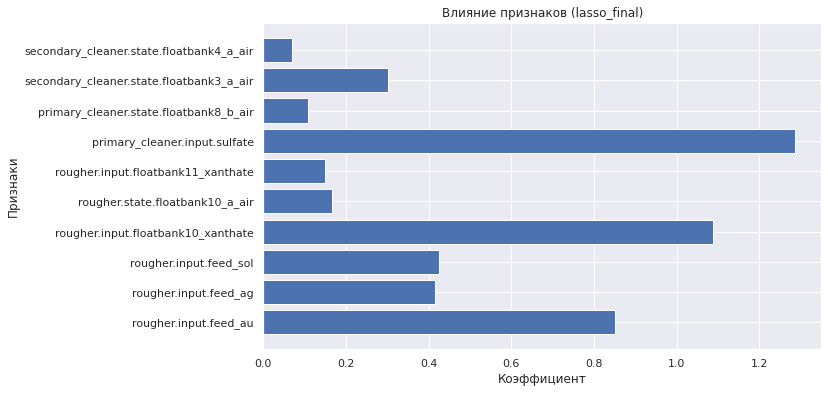

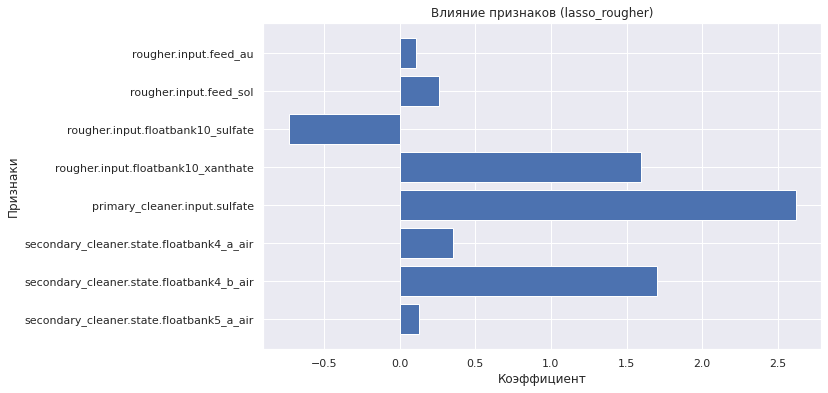

In [ ]:
# создадим гистограмму для модели lasso_final
plt.figure(figsize=(10, 6))
plt.barh(lasso_final_inf, lasso_final.coef_[lasso_final.coef_ != 0])
plt.xlabel('Коэффициент')
plt.ylabel('Признаки')
plt.title('Влияние признаков (lasso_final)')
plt.show()

# создадим гистограмму для модели lasso_rougher
plt.figure(figsize=(10, 6))
plt.barh(lasso_rougher_inf, lasso_rougher.coef_[lasso_rougher.coef_ != 0])
plt.xlabel('Коэффициент')
plt.ylabel('Признаки')
plt.title('Влияние признаков (lasso_rougher)')
plt.gca().invert_yaxis()
plt.show()

В обоих случаях наибольшее влияние на прогнозируемые переменные оказывает признак `primary_cleaner.input.sulfate`.

Проверим модель на адекватность с помощью DummyRegressor:

In [ ]:
dummy_1 = DummyRegressor(strategy = 'median')
dummy_2 = DummyRegressor(strategy = 'median')

dummy_rougher = dummy_1.fit(train_features, train_rougher_target)
dummy_predictions_rougher = dummy_rougher.predict(test_features)

dummy_final = dummy_2.fit(train_features, train_final_target)
dummy_predictions_final = dummy_final.predict(test_features)

smape_rougher_dummy = calculate_smape(test_rougher_target, dummy_predictions_rougher)
smape_final_dummy = calculate_smape(test_final_target, dummy_predictions_final)

print('Итоговый SMAPE Dummy:',calculate_total_smape(smape_rougher_dummy, smape_final_dummy))

Итоговый SMAPE Dummy: 8.266342287585257


Итоговый SMAPE Lasso-регрессии меньше чем у Dummy, а значит модель проходит проверку на адекватность.

## Итоговый вывод

В исследовании нам необходимо было построить модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды, используя данные с параметрами добычи и очистки. В нашем распоряжении были сырые данные, разделенные на 2 выборки: тестовую и обучающую, а также датасет, включающий обе выборки.

На этапе подготовки данных мы удалили часть признаков из обучающей выборки, так как они не доступны в тестовой.

При анализе предоставленных данных нами были замечено, что в датасетах присутствуют вборсы и аномальные значения, когда концентрация металлов в исходном сырье близка к 0. При построении модели такие данные не использовались и были удалены. Возможно, есть ошибки при вычислении концентрации на этапе формировании данных.

Для решения задачи мы сравнили показатели качества пяти моделей: Decision Tree Regressor, Random Forest Regressor, Linear Regression, Lasso-регрессию и Ridge-регрессию. Лучший результат показала Lasso-регрессия, **итоговый SMAPE составил 7.66**, что меньше метрики константной медианной модели (8.26), следовательно, модель прошла проверку на адекватность.